### Imports und GPU Fixes

In [1]:
# Imports
import os
import warnings

# === WARNUNGEN STUMMSCHALTEN ===

# 1. Python-Warnungen
warnings.filterwarnings('ignore')

# 2. TensorFlow C++ Log-Level (z.B. "AVX2", "TF-TRT")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_ENABLE_LAYOUT_OPTIMIZER'] = '0'

# === GPU-FIXES ===

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['XLA_FLAGS'] = '--xla_gpu_strict_conv_algorithm_picker=false'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, RandAugment, CutMix
from tensorflow.keras.optimizers import Adam
import time
import tensorflow.keras.backend as K
import numpy as np
import random
from tensorflow.keras import mixed_precision
import pathlib
from sklearn.model_selection import train_test_split
import keras

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# === GPU-KONFIGURATION ===

# TF32-Fix für GTX 1080 Ti
tf.config.experimental.enable_tensor_float_32_execution(False) 

# Memory Growth
try:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

except RuntimeError as e:
    print(e)

def set_experiment_seed(seed_value):
    """Setzt den globalen Seed für einen reproduzierbaren Experiment-Lauf."""
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    tf.random.set_seed(seed_value)
    np.random.seed(seed_value)
    random.seed(seed_value)

2026-01-04 14:19:12.911449: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-04 14:19:12.933514: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-04 14:19:12.933542: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Konstanten

In [2]:
# ÄNDERN BEI JEDEM UNTERSCHIEDLICHEN EXPERIMENTLAUF
EXPERIMENT_SEED = 44 # Mögliche Werte: 42, 43, 44

#Konstanten NIE ÄNDERN
IMG_SIZE = (224, 224)
INPUT_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE = 16

PLANTDOC_DIR = '/mnt/c/Users/sandr/Desktop/Studium/thesis/praxis/data/plantdoc_cropped'

# Baseline (Modell A) als Startpunkt
SOURCE_MODEL_FILE = f"models/model_A_seed_{EXPERIMENT_SEED}.keras"
    
# Dynamsicher Modellname
MODEL_NAME = f"model_C_seed_{EXPERIMENT_SEED}.keras"

# Setze den Seed für diesen neuen Lauf
set_experiment_seed(EXPERIMENT_SEED)

print(f"Start-Modell: {SOURCE_MODEL_FILE}")
print(f"Ziel-Modellname: {MODEL_NAME}")

Start-Modell: models/model_A_seed_44.keras
Ziel-Modellname: model_C_seed_44.keras


### Laden der Trainings- und Validierungsdaten
* Hier wird das Szenario simuliert, in welchem man nur 30 Bilder pro Klasse zum Finetunen zur Verfügung hat.
* Von diesen 30 Bildern dienen pro Klasse 5 als Validierungsdatensatz, d.h. 25 zum Training und 5 zum Monitoren

In [3]:
from sklearn.model_selection import StratifiedGroupKFold

print("Starte Daten-Vorbereitung mit GROUP-AWARE SPLIT...")

#  Leichte Augmentierung zur Regularisierung, da wenige Daten
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

try:
    data_dir = pathlib.Path(PLANTDOC_DIR)

    # 1. Alle Pfade laden
    image_paths = sorted(list(data_dir.glob('*/*')))
    image_paths = [str(path) for path in image_paths if not pathlib.Path(path).name.startswith('.')]

    # 2. Labels und Group-IDs extrahieren
    class_names = sorted([item.name for item in data_dir.glob('*') if item.is_dir()])
    class_to_index = {name: i for i, name in enumerate(class_names)}
    NUM_CLASSES = len(class_names)
    
    all_labels = []
    all_groups = [] # Hier speichern des Namens des Originalbildes

    for path in image_paths:
        # Label holen
        label = class_to_index[pathlib.Path(path).parent.name]
        all_labels.append(label)
        
        # Group ID holen (Der Name des Originalbildes vor dem _crop_)
        filename = os.path.basename(path)
        # Splitten am letzten "_crop_" Vorkommen, falls der Dateiname selbst "_crop_" enthält
        if "_crop_" in filename:
            group_id = filename.rsplit("_crop_", 1)[0]
        else:
            group_id = filename # Fallback, falls Format anders ist
        all_groups.append(group_id)

    print(f"Gesamt: {len(image_paths)} Bilder in {NUM_CLASSES} Klassen.")
    
    # 3. StratifiedGroupKFold
    # K-Fold mit k=5, um exakt 20% Testdaten zu bekommen (1/5)
    # Das garantiert: Keine Crops desselben Bildes in Train UND Test
    cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=EXPERIMENT_SEED)
    
    # Nehmen des ersten Folds als unseren Split
    train_pool_idx, test_idx = next(cv.split(image_paths, all_labels, all_groups))

    # Konvertieren in Listen
    train_val_paths = [image_paths[i] for i in train_pool_idx]
    train_val_labels = [all_labels[i] for i in train_pool_idx]
    
    test_paths = [image_paths[i] for i in test_idx]
    test_labels = [all_labels[i] for i in test_idx]
    
    print(f"Group-Aware Split -> Pool (80%): {len(train_val_paths)}, Test (20%): {len(test_paths)}")

    # Ziehen der 30 Bilder
    
    final_train_paths = []
    final_train_labels = []
    final_val_paths = []
    final_val_labels = []

    print("\nZiehe 30 Bilder pro Klasse aus dem Pool (25 Train / 5 Val)...")
    
    for cls_idx in range(NUM_CLASSES):
        # Alle Indizes im Pool finden, die zu dieser Klasse gehören
        indices_of_class = [i for i, label in enumerate(train_val_labels) if label == cls_idx]
        
        # Mischen basierend auf Seed
        rng = np.random.default_rng(EXPERIMENT_SEED)
        rng.shuffle(indices_of_class)
        
        # Prüfen ob genug Bilder da sind
        if len(indices_of_class) >= 30:
            selected_indices = indices_of_class[:30]
        else:
            print(f"WARNUNG: Klasse {class_names[cls_idx]} hat im Pool nur {len(indices_of_class)} Bilder!")
            selected_indices = indices_of_class
            
        train_idxs = selected_indices[:-5] 
        val_idxs = selected_indices[-5:]
        
        for idx in train_idxs:
            final_train_paths.append(train_val_paths[idx])
            final_train_labels.append(train_val_labels[idx])
            
        for idx in val_idxs:
            final_val_paths.append(train_val_paths[idx])
            final_val_labels.append(train_val_labels[idx])

    print(f"Fertig.")
    print(f"Few-Shot Train Set: {len(final_train_paths)} Bilder")
    print(f"Few-Shot Val Set:   {len(final_val_paths)} Bilder")
    print(f"Test Set: {len(test_paths)} Bilder")

    # Hilfsfunktionen (unverändert)
    def load_and_preprocess_image(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        return img, tf.one_hot(label, NUM_CLASSES)
    
    def create_dataset(paths, labels, is_training=False):
        ds = tf.data.Dataset.from_tensor_slices((paths, labels))
        if is_training:
            ds = ds.shuffle(buffer_size=len(paths))
            ds = ds.repeat()
        ds = ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        
        if is_training:
            ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                        num_parallel_calls=tf.data.AUTOTUNE)
        
        ds = ds.batch(BATCH_SIZE)
        ds = ds.prefetch(tf.data.AUTOTUNE)
        return ds

    # Datasets erstellen
    ft_train_set = create_dataset(final_train_paths, final_train_labels, is_training=True)
    ft_val_set   = create_dataset(final_val_paths, final_val_labels, is_training=False)

    # Größen für Steps berechnen
    FT_TRAIN_SIZE = len(final_train_paths) // BATCH_SIZE
    FT_VAL_SIZE = len(final_val_paths) // BATCH_SIZE
    
    if len(final_train_paths) % BATCH_SIZE != 0: FT_TRAIN_SIZE += 1
    if len(final_val_paths) % BATCH_SIZE != 0: FT_VAL_SIZE += 1

    print(f"Train Steps per Epoch: {FT_TRAIN_SIZE}")
    print(f"Val Steps per Epoch: {FT_VAL_SIZE}")

except Exception as e:
    print(f"Fehler: {e}")
    import traceback
    traceback.print_exc()

Starte Daten-Vorbereitung mit GROUP-AWARE SPLIT...
Gesamt: 8589 Bilder in 27 Klassen.
Group-Aware Split -> Pool (80%): 6851, Test (20%): 1738

Ziehe exakt 30 Bilder pro Klasse aus dem Pool (25 Train / 5 Val)...
Fertig.
Few-Shot Train Set: 675 Bilder
Few-Shot Val Set:   135 Bilder
Test Set (Unberührt & Leck-Frei): 1738 Bilder
Train Steps per Epoch: 43
Val Steps per Epoch: 9


### FINETUNING: Mit NIEDRIGER LERNRATE auf PlantDoc finetunen

In [4]:
print(f" Starte Fine-Tuning für Modell C...")

# Lade das trainierte MODELL A
print(f"Lade Basis-Modell: {SOURCE_MODEL_FILE}")
model_to_finetune = keras.models.load_model(SOURCE_MODEL_FILE)

# Mit neuer Lernrate neu kompilieren
model_to_finetune.compile(
    optimizer=Adam(learning_rate=5e-5), 
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    jit_compile=False
)

# Callbacks für dieses Experiment definieren
finetune_model_path = f"models/{MODEL_NAME}"

checkpoint_cb_ft = ModelCheckpoint(
    finetune_model_path,
    save_best_only=True,
    monitor="val_loss", 
    mode="min",
    verbose=1
)

early_stopping_cb_ft = EarlyStopping(
    monitor="val_loss", 
    patience=10, # Patience 10 weil das Training volatiler ist
    restore_best_weights=True
)

# Einfrieren überprüfen
def check_params(model):
    trainable = np.sum([K.count_params(w) for w in model.trainable_weights])
    frozen = np.sum([K.count_params(w) for w in model.non_trainable_weights])
    
    print(f"✅ Trainable (aktiv): {int(trainable):,}")
    print(f"❄️ Frozen (inaktiv):  {int(frozen):,}")
    print(f"∑  Total:             {int(trainable + frozen):,}")

# Aufruf
check_params(model_to_finetune)


# Training starten
EPOCHS = 50 
start_zeit = time.time()

history_finetune = model_to_finetune.fit(
    ft_train_set,                 
    validation_data=ft_val_set,  
    epochs=EPOCHS,
    steps_per_epoch=FT_TRAIN_SIZE, 
    validation_steps=FT_VAL_SIZE,  
    callbacks=[checkpoint_cb_ft, early_stopping_cb_ft]
)

end_zeit = time.time()

print(f"\nPhase 3 (Fine-Tuning) abgeschlossen. Dauer: {(end_zeit - start_zeit) / 60:.2f} Minuten")

 Starte Fine-Tuning für Modell C...
Lade Basis-Modell: models/model_A_seed_44.keras
✅ Trainable (aktiv): 4,344,983
❄️ Frozen (inaktiv):  44,583
∑  Total:             4,389,566
Epoch 1/50


2026-01-04 14:19:51.895987: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.2415 - loss: 3.0440
Epoch 1: val_loss improved from None to 2.27860, saving model to models/model_C_seed_44.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 64s 630ms/step - accuracy: 0.2660 - loss: 2.8843 - val_accuracy: 0.3185 - val_loss: 2.2786
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.3883 - loss: 2.2345
Epoch 2: val_loss improved from 2.27860 to 1.99113, saving model to models/model_C_seed_44.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 25s 576ms/step - accuracy: 0.4055 - loss: 2.1811 - val_accuracy: 0.4074 - val_loss: 1.9911
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.4404 - loss: 2.0441
Epoch 3: val_loss improved from 1.99113 to 1.88330, saving model to models/model_C_seed_44.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 470ms/step - accuracy: 0.4622 - loss: 1.9841 - val_accuracy: 0.4519 - val_loss: 1.8833
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.5409 - loss: 1.8628
Epoch 4: val_loss improve

### Trainingsverlauf

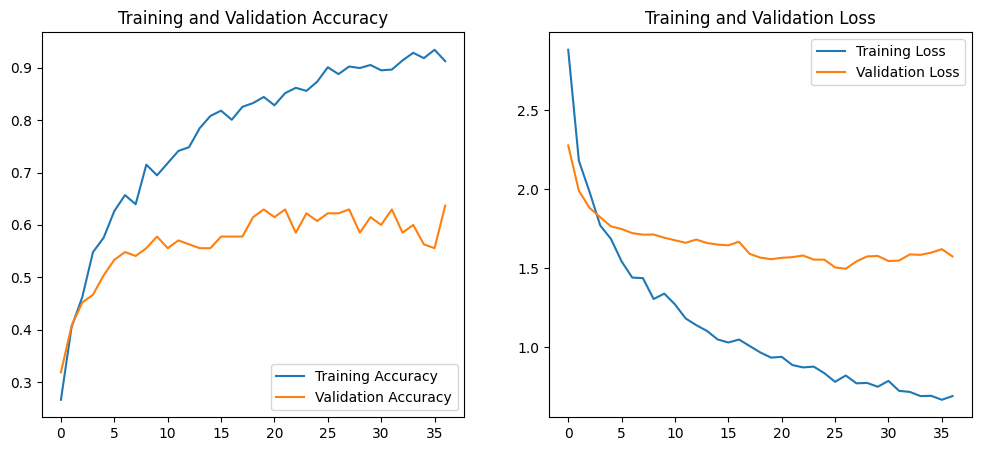

In [5]:
import matplotlib.pyplot as plt

# Daten aus dem 'history'-Objekt
acc = history_finetune.history['accuracy']
val_acc = history_finetune.history['val_accuracy']
loss = history_finetune.history['loss']
val_loss = history_finetune.history['val_loss']

# Epochen, die tatsächlich gelaufen sind.
epochs_range = range(len(acc)) 

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1) # Plot 1: Genauigkeit
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2) # Plot 2: Verlust
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig(f"model_C_seed_{EXPERIMENT_SEED}_training.png")
plt.show()